CODE BLOCK: 1

<!--
>**This is Bold**
>>*This is Italics*
>>>- Simple statement
>>> - `string`
>>>> - $ mathematical symbols $
>>>> 1. Number 1
>>>> 2. Number 2


&#x25BA;


*** -->

# Session 10 - Assignment
## Basic expectations
- Custom ResNet architecture for CIFAR10 that has the following architecture:
  - PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
  - Layer 1
    - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
    - R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k]
    - Add(X, R1)
  - Layer 2
    - Conv 3x3 [256k]
    - MaxPooling2D
    - BN
    - ReLU
  - Layer 3
    - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
    - R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
    - Add(X, R2)
  - MaxPooling with Kernel Size 4
  - FC Layer
  - SoftMax
- Uses One Cycle Policy such that:
  - Total Epochs = 24
  - Max at Epoch = 5
  - LRMIN = FIND
  - LRMAX = FIND
  - NO Annihilation
- Uses this transform
  - RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)
- Batch size = 512
- Use ADAM and CrossEntropyLoss
- Target Accuracy: 90%

### Results:
- Epochs: 24
- Parameters: 6,573,130
- Training Batch size: 512
- Testing Batch size: 512
- max lr: 0.0006280291441834253
- Training
  - Loss=0.0243
  - Accuracy=99.25%
- Testing
  - Average loss: 0.2660
  - Accuracy: 9281/10000 (92.81%)

### Observations:
- Model is overfitting
- Need to see if dropout can be added to have a better fit model
- Should the Augmentations be applied only to few images
- A couple of times saw that the steepest gradient lr is not good enough for model to converge - Rather the lr at the lowest point was better


### [1. Import appropriate modules required in this file](#section-1)
- import model: importing the code written in model.py that is kept in path of current working directory
- import utils: Similarly importing code in utils.py

In [1]:
# !pip install torchsummary
!pip install torch-lr-finder

In [2]:
!git clone https://github.com/ChintanShahDS/ERAV2_Vision

Cloning into 'ERAV2_Vision'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 33 (delta 15), reused 26 (delta 11), pack-reused 0
Receiving objects: 100% (33/33), 7.45 KiB | 7.45 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
# import sys
# sys.path.append('/ERAV2_Vision')

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from ERAV2_Vision.Dataset_Transforms import Cifar10Dataset, dataloader
from ERAV2_Vision.visualize import showIncorrectPreds, drawLossAccuracyPlots, visualizeData
from ERAV2_Vision.CustomDavidResNet_model import CustomDavidResNet
from ERAV2_Vision.train_test import train, test, find_maxlr, incorrectOutcomes

CODE BLOCK: 2

### [2. Check if GPU (CUDA) or CPU](#section-2)
- Cuda availablbility check to ensure using GPU if available for the network
- Taking the value into device variable if cuda (GPU) or only CPU

In [7]:
SEED = 1

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if device=="cuda":
    torch.cuda.manual_seed(SEED)

CUDA Available? True


CODE BLOCK: 3

### [3. Data transforms for training and testing](#section-3)
- Transforms specific to the training and testing
- Training to include different transformations for the model to learn
- Testing not to have the same to ensure validation is on normal set

### [4. Getting the CIFAR10 train and test dataset from torchvision datasets library](#section-4)
- Already separated datasets for train and test
- train with *50000* records and test with *10000* records
- Marking train as True of False decides the train vs test data sets
- The transforms are being loaded from utils file
- transforms being done on train but not on test

In [8]:
train_data = Cifar10Dataset(root="./data", train=True, download=True, transform='train')
test_data = Cifar10Dataset(root="./data", train=False, download=True, transform='test')

classes = train_data.classes
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 5

### [5. Data loader setup for Training and Testing](#section-5)
- Batch size definition - Keeping separate for Training and Testing
- Training lower for better training and Testing higher for faster validation
- Data loader definition

In [9]:
batch_size = 512

In [10]:
dataloader_args = dict(batch_size=512, shuffle=True, num_workers=4, pin_memory=True)

train_loader = dataloader(train_data, dataloader_args)
test_loader = dataloader(test_data, dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 6

### [6. Data Visualization](#section-6)
- Visualization of data to understand the images and corresponding labels
- Also gives an understanding of the dataloader like Shuffle, etc.

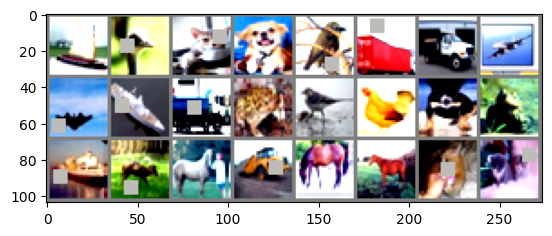

ship  bird  cat   dog   bird  truck truck airplane airplane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat  


In [11]:
num_images = 24

visualizeData(train_loader, num_images, classes)

CODE BLOCK: 10

### [7. Model training](#section-7)
- Loading the model on the right device - CUDA or CPU
- Setting up the right parameters like epochs, optimizer and scheduler for the training
- Running the training and validating the output against Test dataset
- While doing that also storing the loss and accuracy results for each epoch for understanding

In [12]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [13]:
mymodel = CustomDavidResNet().to(device)
torch.save(mymodel, 'InitialModel.pth')
summary(mymodel, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
       BatchNorm2d-4          [-1, 128, 16, 16]             256
            Conv2d-5          [-1, 128, 16, 16]         147,456
       BatchNorm2d-6          [-1, 128, 16, 16]             256
            Conv2d-7          [-1, 128, 16, 16]         147,456
       BatchNorm2d-8          [-1, 128, 16, 16]             256
            Conv2d-9          [-1, 256, 16, 16]         294,912
      BatchNorm2d-10            [-1, 256, 8, 8]             512
           Conv2d-11            [-1, 512, 8, 8]       1,179,648
      BatchNorm2d-12            [-1, 512, 4, 4]           1,024
           Conv2d-13            [-1, 512, 4, 4]       2,359,296
      BatchNorm2d-14            [-1, 51

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.28E-04


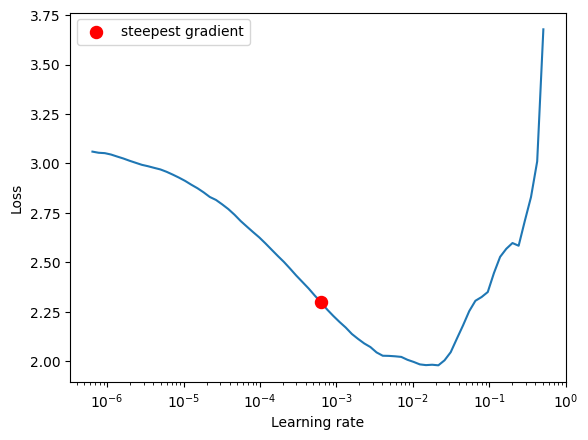

max_LR: 0.0006280291441834253


In [14]:
mymodel = torch.load('InitialModel.pth')
maxlr = find_maxlr(mymodel,train_loader,test_loader)

In [15]:
mymodel = torch.load('InitialModel.pth')

num_epochs = 24
max_lr_epoch = 5
# maxlr = 0.01 to try with the lowest part of the graph
optimizer = optim.Adam(mymodel.parameters(), lr=0.01)
# optimizer = optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, div_factor=10,
                                                final_div_factor=10, steps_per_epoch=len(train_loader),
                                                epochs=num_epochs, pct_start=max_lr_epoch/num_epochs,
                                                three_phase=False, anneal_strategy='linear')
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, threshold_mode='rel', verbose=True)
criterion = F.cross_entropy
# loss=torch.nn.CrossEntropyLoss()
# criterion = F.nll_loss

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = train(mymodel, device, train_loader, optimizer, criterion, scheduler)
  test_acc, test_loss = test(mymodel, device, test_loader, criterion)
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  test_accs.append(test_acc)
  test_losses.append(test_loss)

Epoch 1


Train: Loss=1.0662 Batch_id=97 Accuracy=47.26: 100%|██████████| 98/98 [00:18<00:00,  5.38it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 1.4796, Accuracy: 23630/50000 (47.26%)
Last computed learning rate: [0.00017607933674345115]
LR Rate: 0.00017607933674345115


Test set: Average loss: 1.1271, Accuracy: 5928/10000 (59.28%)
Epoch 2


Train: Loss=0.8371 Batch_id=97 Accuracy=65.37: 100%|██████████| 98/98 [00:18<00:00,  5.23it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.9840, Accuracy: 32684/50000 (65.37%)
Last computed learning rate: [0.00028935575906855973]
LR Rate: 0.00028935575906855973


Test set: Average loss: 0.9595, Accuracy: 6640/10000 (66.40%)
Epoch 3


Train: Loss=0.7426 Batch_id=97 Accuracy=73.35: 100%|██████████| 98/98 [00:18<00:00,  5.28it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.7666, Accuracy: 36675/50000 (73.35%)
Last computed learning rate: [0.00040263218139366836]
LR Rate: 0.00040263218139366836


Test set: Average loss: 0.7645, Accuracy: 7437/10000 (74.37%)
Epoch 4


Train: Loss=0.5777 Batch_id=97 Accuracy=78.01: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.6386, Accuracy: 39006/50000 (78.01%)
Last computed learning rate: [0.0005159086037187769]
LR Rate: 0.0005159086037187769


Test set: Average loss: 0.6622, Accuracy: 7780/10000 (77.80%)
Epoch 5


Train: Loss=0.4996 Batch_id=97 Accuracy=81.16: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.5437, Accuracy: 40582/50000 (81.16%)
Last computed learning rate: [0.000627695229654563]
LR Rate: 0.000627695229654563


Test set: Average loss: 0.5904, Accuracy: 8003/10000 (80.03%)
Epoch 6


Train: Loss=0.4283 Batch_id=97 Accuracy=84.21: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.4600, Accuracy: 42105/50000 (84.21%)
Last computed learning rate: [0.0005949716058260582]
LR Rate: 0.0005949716058260582


Test set: Average loss: 0.4795, Accuracy: 8348/10000 (83.48%)
Epoch 7


Train: Loss=0.3742 Batch_id=97 Accuracy=86.65: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.3857, Accuracy: 43325/50000 (86.65%)
Last computed learning rate: [0.0005622479819975535]
LR Rate: 0.0005622479819975535


Test set: Average loss: 0.5182, Accuracy: 8264/10000 (82.64%)
Epoch 8


Train: Loss=0.3764 Batch_id=97 Accuracy=88.44: 100%|██████████| 98/98 [00:19<00:00,  5.06it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.3335, Accuracy: 44219/50000 (88.44%)
Last computed learning rate: [0.0005295243581690486]
LR Rate: 0.0005295243581690486


Test set: Average loss: 0.4073, Accuracy: 8622/10000 (86.22%)
Epoch 9


Train: Loss=0.3044 Batch_id=97 Accuracy=90.34: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.2849, Accuracy: 45168/50000 (90.34%)
Last computed learning rate: [0.0004968007343405438]
LR Rate: 0.0004968007343405438


Test set: Average loss: 0.4080, Accuracy: 8588/10000 (85.88%)
Epoch 10


Train: Loss=0.2648 Batch_id=97 Accuracy=91.34: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.2562, Accuracy: 45671/50000 (91.34%)
Last computed learning rate: [0.000464077110512039]
LR Rate: 0.000464077110512039


Test set: Average loss: 0.4163, Accuracy: 8622/10000 (86.22%)
Epoch 11


Train: Loss=0.2311 Batch_id=97 Accuracy=92.50: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.2191, Accuracy: 46251/50000 (92.50%)
Last computed learning rate: [0.00043135348668353423]
LR Rate: 0.00043135348668353423


Test set: Average loss: 0.3644, Accuracy: 8794/10000 (87.94%)
Epoch 12


Train: Loss=0.1790 Batch_id=97 Accuracy=93.57: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.1924, Accuracy: 46784/50000 (93.57%)
Last computed learning rate: [0.00039862986285502946]
LR Rate: 0.00039862986285502946


Test set: Average loss: 0.3596, Accuracy: 8824/10000 (88.24%)
Epoch 13


Train: Loss=0.1513 Batch_id=97 Accuracy=94.50: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.1649, Accuracy: 47248/50000 (94.50%)
Last computed learning rate: [0.00036590623902652464]
LR Rate: 0.00036590623902652464


Test set: Average loss: 0.3471, Accuracy: 8871/10000 (88.71%)
Epoch 14


Train: Loss=0.1508 Batch_id=97 Accuracy=95.26: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.1441, Accuracy: 47629/50000 (95.26%)
Last computed learning rate: [0.00033318261519801987]
LR Rate: 0.00033318261519801987


Test set: Average loss: 0.3989, Accuracy: 8719/10000 (87.19%)
Epoch 15


Train: Loss=0.1464 Batch_id=97 Accuracy=95.81: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.1271, Accuracy: 47905/50000 (95.81%)
Last computed learning rate: [0.00030045899136951505]
LR Rate: 0.00030045899136951505


Test set: Average loss: 0.3589, Accuracy: 8896/10000 (88.96%)
Epoch 16


Train: Loss=0.1159 Batch_id=97 Accuracy=96.58: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.1092, Accuracy: 48289/50000 (96.58%)
Last computed learning rate: [0.0002677353675410103]
LR Rate: 0.0002677353675410103


Test set: Average loss: 0.3257, Accuracy: 8970/10000 (89.70%)
Epoch 17


Train: Loss=0.0881 Batch_id=97 Accuracy=96.95: 100%|██████████| 98/98 [00:19<00:00,  5.05it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.0960, Accuracy: 48474/50000 (96.95%)
Last computed learning rate: [0.00023501174371250546]
LR Rate: 0.00023501174371250546


Test set: Average loss: 0.3352, Accuracy: 8960/10000 (89.60%)
Epoch 18


Train: Loss=0.1178 Batch_id=97 Accuracy=97.36: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]



Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.0848, Accuracy: 48682/50000 (97.36%)
Last computed learning rate: [0.00020228811988400063]
LR Rate: 0.00020228811988400063
Test set: Average loss: 0.3084, Accuracy: 9011/10000 (90.11%)
Epoch 19


Train: Loss=0.0638 Batch_id=97 Accuracy=97.91: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.0699, Accuracy: 48954/50000 (97.91%)
Last computed learning rate: [0.00016956449605549587]
LR Rate: 0.00016956449605549587


Test set: Average loss: 0.3185, Accuracy: 8992/10000 (89.92%)
Epoch 20


Train: Loss=0.0377 Batch_id=97 Accuracy=98.29: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.0592, Accuracy: 49146/50000 (98.29%)
Last computed learning rate: [0.0001368408722269911]
LR Rate: 0.0001368408722269911


Test set: Average loss: 0.3013, Accuracy: 9097/10000 (90.97%)
Epoch 21


Train: Loss=0.0593 Batch_id=97 Accuracy=98.48: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.0518, Accuracy: 49241/50000 (98.48%)
Last computed learning rate: [0.00010411724839848628]
LR Rate: 0.00010411724839848628


Test set: Average loss: 0.2939, Accuracy: 9083/10000 (90.83%)
Epoch 22


Train: Loss=0.0410 Batch_id=97 Accuracy=98.81: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.0441, Accuracy: 49407/50000 (98.81%)
Last computed learning rate: [7.139362456998145e-05]
LR Rate: 7.139362456998145e-05


Test set: Average loss: 0.2957, Accuracy: 9097/10000 (90.97%)
Epoch 23


Train: Loss=0.0381 Batch_id=97 Accuracy=98.98: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.0387, Accuracy: 49490/50000 (98.98%)
Last computed learning rate: [3.867000074147674e-05]
LR Rate: 3.867000074147674e-05


Test set: Average loss: 0.2841, Accuracy: 9132/10000 (91.32%)
Epoch 24


Train: Loss=0.0190 Batch_id=97 Accuracy=99.15: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]


Processed: 50000, Len TrainLoader: 98
Train set: Average loss: 0.0345, Accuracy: 49577/50000 (99.15%)
Last computed learning rate: [5.9463769129719166e-06]
LR Rate: 5.9463769129719166e-06


Test set: Average loss: 0.2831, Accuracy: 9132/10000 (91.32%)


CODE BLOCK: 11

### [8. Model Accuracy and Loss plots visualization](#section-8)
- Part of utils
- Drawing plots of Training and Testing accuracy and loss
- This gives us an understanding of how the accuracy and losses improved over epochs
- Also helps to understand where we should have stopped the training for optimum results

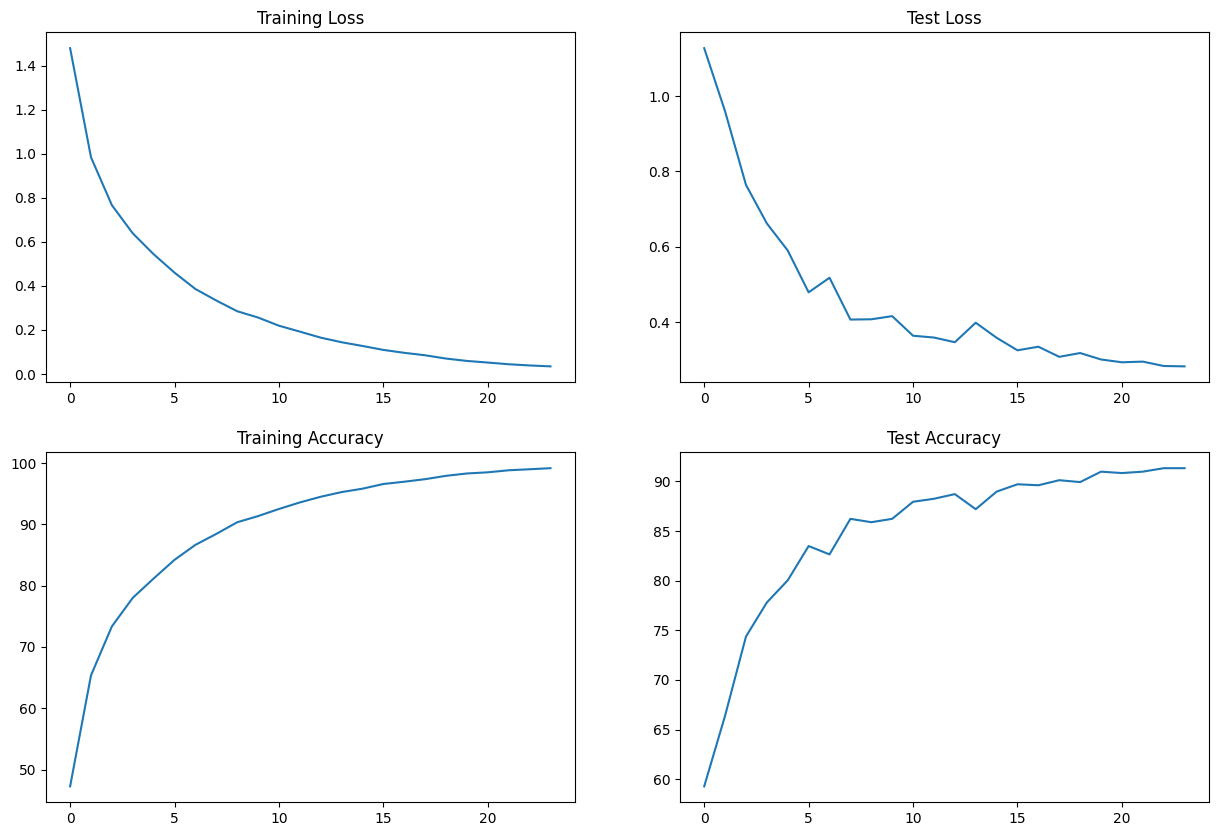

In [16]:
drawLossAccuracyPlots(train_losses, train_accs, test_losses, test_accs)

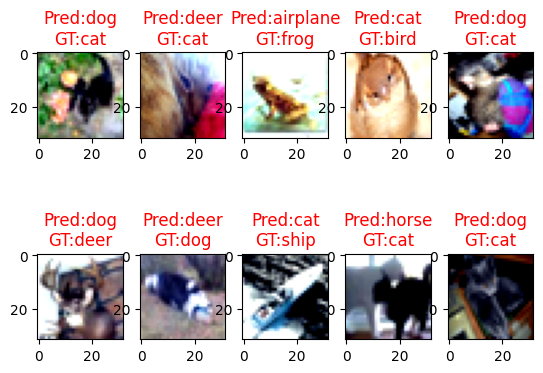

In [17]:
numImages = 10
images, nonMatchingLabels, incorrectPreds = incorrectOutcomes(mymodel, device, test_loader, numImages)
showIncorrectPreds(numImages, images, incorrectPreds, nonMatchingLabels,classes)